In [ ]:
import sys
from google.colab import drive
drive.mount('/content/drive')
sys.path.append('/content/drive/My Drive/Final_Project_RuiZhou')

sys.path.append("path")

BASEOUTDIR = r'/content/drive/My Drive/Final_Project_RuiZhou'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


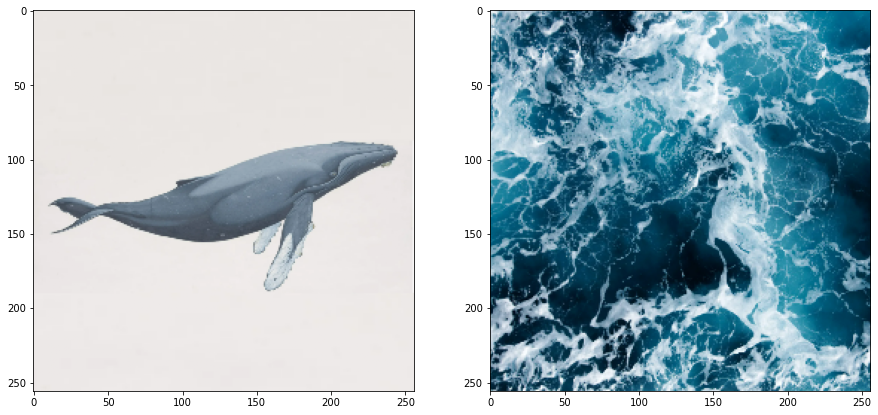

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from scipy.optimize import fmin_l_bfgs_b
import matplotlib.pyplot as plt
import numpy as np
import os
import decoders
from helpers import initialize_image, gram_matrix, gram_loss, slice_loss

SIZE = 256


content_image = decoders.decode_image("/content/drive/My Drive/Final_Project_RuiZhou/StyleTransfer/content.png", SIZE)
style_image = decoders.decode_image("/content/drive/My Drive/Final_Project_RuiZhou/StyleTransfer/style.png", SIZE)

fig ,(ax1,ax2) = plt.subplots(1, 2,figsize=(15,15))
ax1.imshow(tf.squeeze(content_image, axis=0))
ax2.imshow(tf.squeeze(style_image, axis=0))

In [ ]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)
  return model


def vgg_layers_custom(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # A customized vgg is used as explained in the supplementals.
  vgg = keras.models.load_model('/content/drive/My Drive/Final_Project_RuiZhou/vgg_customized.h5')
  vgg.trainable = False
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)
  return model

In [ ]:
"""The loss function is implemented in class Slicing(...) and is used by ExtractorVggModel which directly returns loss """
class Slicing(tf.keras.layers.Layer):
    """ Slicing layer: computes projections and returns sorted vector """
    def __init__(self, num_slices):
        super().__init__()
        # Number of directions
        self.num_slices = num_slices
        self.flatten_layer = tf.keras.layers.Flatten()

    def update_slices(self):
        """ Update random directions """
        # Generate random directions
        self.directions = tf.random.normal(shape=(self.num_slices, self.dim_slices))
        # Normalize directions
        norm = tf.reshape( K.sqrt( K.sum( K.square(self.directions), axis=-1 )), (self.num_slices, 1))
        self.directions = tf.divide(self.directions, norm)

    def build(self, input_shape):
        self.dim_slices = input_shape[-1]
        self.update_slices()

    def call(self, input):
        """ Implementation of figure 2 """
        tensor = tf.reshape(input, (tf.shape(input)[0], -1, tf.shape(input)[-1]))
        # Project each pixel feature onto directions (batch dot product)
        sliced = self.directions @ tf.transpose(tensor, perm=[0,2,1])
        # Sort projections for each direction
        sliced = tf.sort(sliced)
        
        return self.flatten_layer(sliced)

class ExtractorVggModelCustom(tf.keras.Model):
    """ Extract stats using a pretrained vgg and return slices vectors"""
    def __init__(self, layers):
        super().__init__()
        self.vgg =  vgg_layers_custom(layers)
        self.vgg.trainable = False    

        self.slicing_losses = [Slicing(num_slices=l.shape[-1]) for i, l in enumerate(self.vgg.outputs)]

    def update_slices(self):
        for slice_loss in self.slicing_losses:
            slice_loss.update_slices()

    def call(self, inputs):
        outputs = self.vgg(inputs)
        outputs = [self.slicing_losses[i](output)
                        for i, output in enumerate(outputs)]

        return outputs

class ExtractorVggModel(tf.keras.Model):
    """ Extract stats using a pretrained vgg and return slices vectors"""
    def __init__(self, layers):
        super().__init__()
        self.vgg =  vgg_layers(layers)
        self.vgg.trainable = False    

        self.slicing_losses = [Slicing(num_slices=l.shape[-1]) for i, l in enumerate(self.vgg.outputs)]

    def update_slices(self):
        for slice_loss in self.slicing_losses:
            slice_loss.update_slices()

    def call(self, inputs):
        outputs = self.vgg(inputs)
        outputs = [self.slicing_losses[i](output)
                        for i, output in enumerate(outputs)]

        return outputs

In [ ]:
def loss_and_grad_slice(image, *args):
    """ Return loss and grad for a step. Called by lbfgs optimize  """
    image_tf = tf.constant(np.reshape(image, (1,SIZE,SIZE,3)), dtype='float32')
    args = args[0]
    extractor = args['extractor']
    targets = args['targets']

    with tf.GradientTape() as tape:
        tape.watch(image_tf) 
        outputs = extractor(image_tf)
        #L2 between the sorted slices (generated image vs target texture)
        losses =[tf.reduce_mean((output-targets[i])**2) 
                           for i, output in enumerate(outputs)]
        loss = tf.add_n(losses)
    
    grad_raw = tape.gradient(loss, image_tf)    
    grad = np.reshape(grad_raw.numpy(), (SIZE*SIZE*3,))
    loss = np.reshape(loss.numpy(), (1))  

    return loss.astype('float64'), grad.astype('float64')

def fit_slice(nb_iter, style, content, extractor):
    targets = extractor(style)
    image = content

    for i in range(nb_iter):
      arg_opt = {'extractor': extractor, 'targets':targets}
      image, loss, info = fmin_l_bfgs_b(func=loss_and_grad_slice, args=[arg_opt], x0=image, maxfun=64, pgtol=0.0, factr=0.0)
      image = np.clip(image, 0, 1)
      print(f'iter {i+1} loss {loss}')
    
      # Change random directions (optional)
      extractor.update_slices()
      targets = extractor(style)

      # compare current gram loss with sw loss
      image = np.reshape(image, (1,SIZE, SIZE, 3))
            
    return image

80150528/80134624 [==============================] - 0s 0us/step
iter 1 loss [0.04586066]
iter 2 loss [0.02999391]
iter 3 loss [0.02541449]
iter 4 loss [0.02432628]
iter 5 loss [0.02318977]
iter 1 loss [2.08494854]
iter 2 loss [1.40357065]
iter 3 loss [1.22052765]
iter 4 loss [1.08222377]
iter 5 loss [0.98899162]


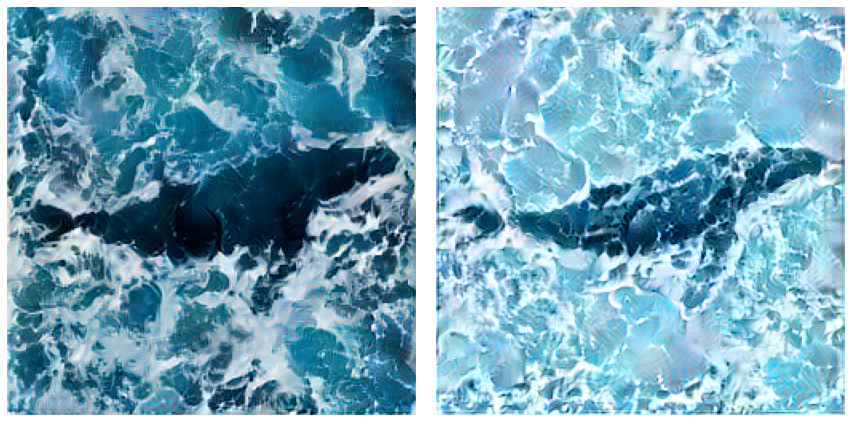

In [ ]:
# VGG layers used for the loss
layers = ['block1_conv1',
          'block1_conv2',
          'block2_conv1',
          'block2_conv2',
          'block3_conv1', 
          'block3_conv2',
          'block3_conv3',
          'block3_conv4',
          'block4_conv1', 
          'block4_conv2',
          'block4_conv3',
          'block4_conv4',
          'block5_conv1',
          'block5_conv2'
          ]

NB_ITER = 5
slice_extractor = ExtractorVggModel(layers)
slice_extractor_custom = ExtractorVggModelCustom(layers)

output_image_custom = fit_slice(NB_ITER, style_image, content_image, slice_extractor_custom)
output_image = fit_slice(NB_ITER, style_image, content_image, slice_extractor)

fig ,(ax1, ax2) = plt.subplots(1, 2,figsize=(15,15))
ax1.imshow(output_image_custom[0,:,:,:])
ax1.axis('off')
ax2.imshow(output_image[0,:,:,:])
ax2.axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0)

iter 1 loss [0.01001158]
iter 2 loss [0.00704859]
iter 3 loss [0.00610707]
iter 4 loss [0.00577737]
iter 5 loss [0.00526037]
iter 1 loss [0.40688688]
iter 2 loss [0.32582071]
iter 3 loss [0.30999583]
iter 4 loss [0.28550878]
iter 5 loss [0.25641593]


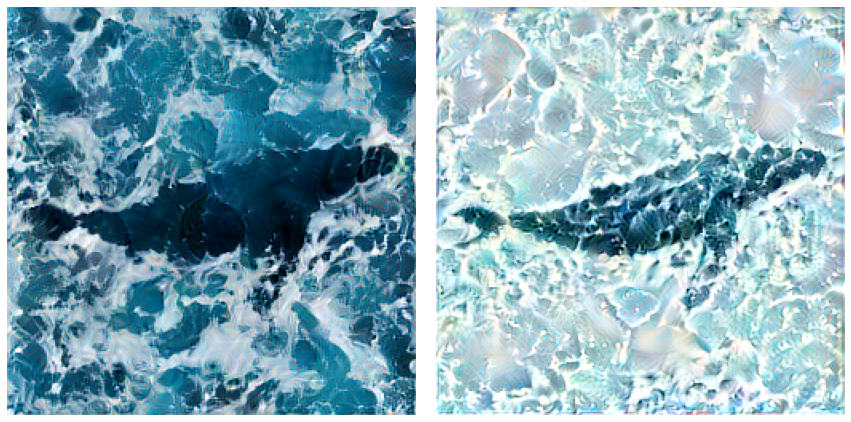

In [ ]:
layers = ['block1_conv1',
          'block2_conv1',
          'block3_conv1', 
          'block4_conv1', 
          'block5_conv1']

slice_extractor = ExtractorVggModel(layers)
slice_extractor_custom = ExtractorVggModelCustom(layers)

NB_ITER = 5
output_image_custom2 = fit_slice(NB_ITER, style_image, content_image, slice_extractor_custom)
output_image2 = fit_slice(NB_ITER, style_image, content_image, slice_extractor)

fig ,(ax1, ax2) = plt.subplots(1, 2,figsize=(15,15))
ax1.imshow(output_image_custom2[0,:,:,:])
ax1.axis('off')
ax2.imshow(output_image2[0,:,:,:])
ax2.axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0)

iter 1 loss [0.01921987]
iter 2 loss [0.00869034]
iter 3 loss [0.00646681]
iter 4 loss [0.00538739]
iter 5 loss [0.00485225]
iter 1 loss [93.12503052]
iter 2 loss [57.0762558]
iter 3 loss [45.19533539]
iter 4 loss [39.2895813]
iter 5 loss [33.67368317]


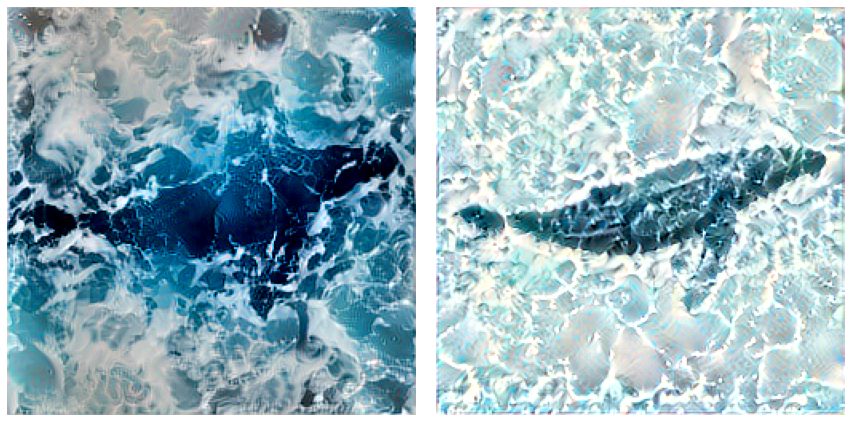

In [ ]:
def loss_and_grad_gram(image, *args):
    """ Return loss and grad for a step. Called by lbfgs optimize  """
    image_tf = tf.constant(np.reshape(image, (1,SIZE,SIZE,3)), dtype='float32')
    args = args[0]
    targets = args['targets']
    extractor = args['extractor']
    gram_target = [gram_matrix(feature) for feature in targets]

    with tf.GradientTape() as tape:
        tape.watch(image_tf) 
        gram_image = [gram_matrix(feature) for feature in extractor(image_tf)]
        #L2 between the sorted slices (generated image vs target texture)
        loss = tf.add_n([tf.reduce_mean((gram_image[idx]-gram_target[idx])**2) for idx,_ in enumerate(gram_image)])
    
    grad_raw = tape.gradient(loss, image_tf)    
    grad = np.reshape(grad_raw.numpy(), (SIZE*SIZE*3,))
    loss = np.reshape(loss.numpy(), (1))  

    return loss.astype('float64'), grad.astype('float64')

def fit_gram(nb_iter, style, content, extractor):
    targets = extractor(style)
    image = content

    for i in range(nb_iter):
        arg_opt = {'extractor': extractor, 'targets':targets}

        image, loss, info = fmin_l_bfgs_b(func=loss_and_grad_gram, args=[arg_opt], x0=image, maxfun=64, pgtol=0.0, factr=0.0)
        image = np.clip(image, 0, 1)
        print(f'iter {i+1} loss {loss}')

        # compare current gram loss with sw loss
        image = np.reshape(image, (1,SIZE, SIZE, 3)).astype('float32')
            
    return image

# VGG layers used for the loss
layers = ['block1_conv1',
          'block1_conv2',
          'block2_conv1',
          'block2_conv2',
          'block3_conv1', 
          'block3_conv2',
          'block3_conv3',
          'block3_conv4',
          'block4_conv1', 
          'block4_conv2',
          'block4_conv3',
          'block4_conv4',
          'block5_conv1',
          'block5_conv2'
          ]

NB_ITER = 5
gram_extractor = vgg_layers(layers)
gram_extractor_custom = vgg_layers_custom(layers)

output_image_custom_gram = fit_gram(NB_ITER, style_image, content_image, gram_extractor_custom)
output_image_gram = fit_gram(NB_ITER, style_image, content_image, gram_extractor)

fig ,(ax1, ax2) = plt.subplots(1, 2,figsize=(15,15))
ax1.imshow(output_image_custom_gram[0,:,:,:])
ax1.axis('off')
ax2.imshow(output_image_gram[0,:,:,:])
ax2.axis('off')
plt.subplots_adjust(wspace=0.05, hspace=0)